# **Assignment #1: Sequence Labeling**
## Natural Language Processing
### Alberto Luise, Angelo Quarta, Edoardo Fusa

<p>&nbsp;</p>

#### This task consist in tackling the problem of Part-of-speech tagging using different Models involving LSTMs; our AI algorithms should be able to learn to correctly classify each word in a given sentence based on both its definition and its context. 


#### We will try a couple of different approaches, while also giving an important role to visualization. Every model in this notebook will be trained locally on an Nvidia GeForce 3060 with 12GB of VRAM.

In [1]:
import pathlib
import pandas as pd
import numpy as np
import urllib
import zipfile
import os
import collections
import string
import matplotlib.pyplot as plt
import random
import pickle
import itertools
from wordcloud import WordCloud

import POS_utility
import importlib

# 1) Getting Started
<p>&nbsp;</p>

#### The first step is obviously to download and prepare the dataset; we'll first verify if we have already downloaded the files, and if not we'll request them and unzip them (we'll do the same everytime downloading something is needed).

#### After that, we'll build a Dataframe with all available samples, dividing them in Training, Validation & Test sets.

In [2]:
Data_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
print(f"Download folder: {pathlib.Path.cwd()}")
dataset_folder = pathlib.Path.cwd().joinpath("Datasets")
raw_data_folder = dataset_folder.joinpath("dependency_treebank")

if not dataset_folder.exists():  # Creating folder
    dataset_folder.mkdir(parents=True)
if not raw_data_folder.exists():  # Downloading dataset
    print("Retrieving Dataset...")
    filename = dataset_folder.joinpath("Assignment_Dataset.zip")
    urllib.request.urlretrieve(url=Data_url, filename=filename)
    print("Download finished! Extracting...")
    zipper = zipfile.ZipFile(filename, 'r') 
    zipper.extractall(dataset_folder) # Downloaded file is compressed; extracting

Download folder: C:\Users\Alber\Documents\Notebooks\Assignment_1


In [3]:
rows = []
for r, subset in [(range(1, 101), "train"), (range(101, 151), "val"), (range(151, 200), "test")]:
    # Iterating over the 200 files, dividing into Train, Val, Test sets
    for i in r:
        f = open(raw_data_folder.joinpath("wsj_" + str(i).zfill(4) + ".dp"),  "r")
        for line in f.readlines():  # Reading word-by-word
            if line == "\n":
                continue
            (word, pos, _) = line.split()  # Ignoring the third attribute of the original dataset
            dataframe_row = {
                        "Sentence_ID": i,  # Which sentence is the word part of
                        "set": subset,     # Which set is the corresponding sentence part of
                        "text": word,      # The actual word as a string
                        "POS": pos         # Our target class
                    }
            rows.append(dataframe_row)
        f.close()
df = pd.DataFrame(rows)
df = df[["Sentence_ID", "set", "text", "POS"]]

In [4]:
print("Complete Dataframe:")
print(df)
print()

print("Distribution of words: ")
print(df['set'].value_counts())
print()

Complete Dataframe:
       Sentence_ID    set     text  POS
0                1  train   Pierre  NNP
1                1  train   Vinken  NNP
2                1  train        ,    ,
3                1  train       61   CD
4                1  train    years  NNS
...            ...    ...      ...  ...
94079          199   test  quarter   NN
94080          199   test       of   IN
94081          199   test     next   JJ
94082          199   test     year   NN
94083          199   test        .    .

[94084 rows x 4 columns]

Distribution of words: 
set
train    47356
val      31183
test     15545
Name: count, dtype: int64



13000 13166
14000


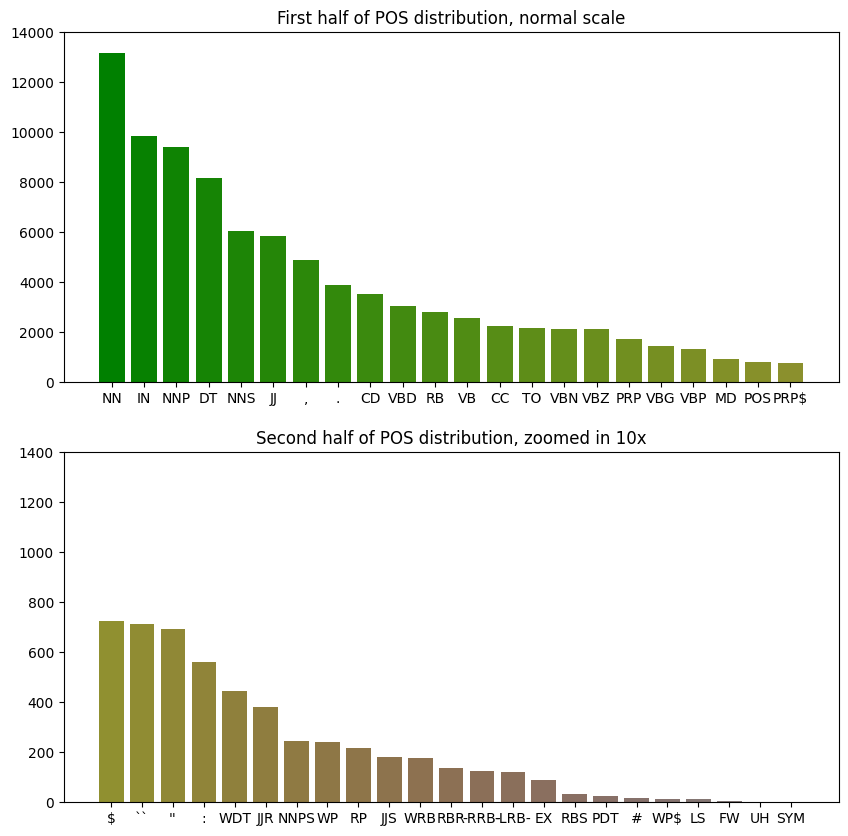

In [5]:
hist = df['POS'].value_counts().to_frame()
POS_utility.plot_unbalanced_series(hist, 10)

The POS column has some values (e.g. FW, UH, SYM) that are extremely rare, appearing only a single-digit number of times in 94k examples. These could reveal to be really hard to learn & recognize, & significally impact the Macro F1 Score, which is averaged over classes.

# 2) Preparing our Vocabulary

<p>&nbsp;</p>

#### Since our machine only understands numbers, we have to embed the words before using them as input data. We'll use GloVe Embedding (Global Vectors), an unsupervised algorithm based on co-occurrence statistics from a specific corpus.Also, since we'll be only downloading the pre-trained embeddings, we'll have plenty of Out-of-vocabulary words.

#### Before we do that however, we first have to build a dictionary with all our words to be converted.

In [6]:
def build_vocabulary(df):
    """
    Defines a vocabulary, returning both an 'Index-to-Word' version and a 'Word-to-Index' version.
    Done with a for loop since Pandas functions can be really slow.
    
    Arguments: {df: pandas.DataFrame}
    
    Returns: (collections.OrderedDict(), collections.OrderedDict())
    """
    Index_to_Word = collections.OrderedDict()  # To emulate a sklearn Encoder, we build two dictionaries
    Word_to_Index = collections.OrderedDict()  #   in order to be able to decode Indexes if needed 
    
    idx = 0
    for token in df['text'].unique():
        if token not in Word_to_Index:
            Word_to_Index[token] = idx
            Index_to_Word[idx] = token
            idx += 1

    return Index_to_Word, Word_to_Index
# Do I leave it in main or put it into utility?

df['text'] = df['text'].str.lower()  # Put all words as lowercase, to reduce dictionary size
df['text'] = df['text'].str.strip()  # Remove leftover spaces around words

idx_to_word, word_to_idx = build_vocabulary(df[df['set'] == 'train'])
# We build our vocabulary using only the training set, as looking at the test set would be "cheating"
print(f'Vocabulary entries: {len(idx_to_word)}')
print(f'Some words: {[(idx_to_word[idx], idx) for idx in np.arange(8)]}')

Vocabulary entries: 7404
Some words: [('pierre', 0), ('vinken', 1), (',', 2), ('61', 3), ('years', 4), ('old', 5), ('will', 6), ('join', 7)]


In [7]:
# Optional: save the vocabulary to a JSON for manual inspection
SAVE_VOC = False 

if SAVE_VOC:
    import simplejson as sj

    vocab_path = pathlib.Path.cwd().joinpath('Datasets', 'Vocabulary.json')

    print(f"Saving vocabulary to {vocab_path}")
    with vocab_path.open(mode='w') as f:
        sj.dump(word_to_idx, f, indent=4)
    print("Saving completed!")

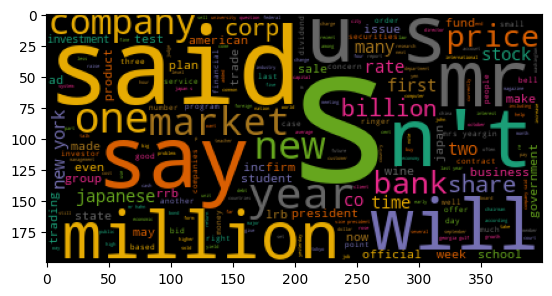

In [8]:
# A bit of visualization
q_S = ' '.join(df[df['set']=='train']['text'])
wordcloud_S = WordCloud(max_font_size=None,scale = 1,colormap = 'Dark2').generate(q_S)
plt.imshow(wordcloud_S)

Once our dictionary is complete, we can build a Tokenizer from the Keras library and fit it on our dictionary; after that, we download the pre-trained embeddings as a simple text file, read them & apply them accordingly, leaving a row full of 0s if no embedding is found.

In [9]:
from keras import preprocessing

tokenizer = preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

glove_folder = pathlib.Path.cwd().joinpath("GloVe")
if not glove_folder.exists():
    print("Embeddings not found; Downloading...")
    glove_folder.mkdir(parents=True)
    filename_2 = glove_folder.joinpath("GloVe.zip")
    urllib.request.urlretrieve(url='http://nlp.stanford.edu/data/glove.6B.zip', filename=filename_2)
    print("Download finished! Extracting...")
    with zipfile.ZipFile(filename_2, 'r') as zip_ref:
        zip_ref.extractall(glove_folder)


Found 10947 unique tokens.


In [10]:
def embedding_for_vocab(filepath, word_index, embedding_dim): 
    """
    Applies pre-trained embeddings stored locally onto a vocabulary, to be used as encoder.
    
    Arguments: {filepath: Path to the file containing the embeddings;
                word_index: keras.preprocessing.text.Tokenizer.word_index, Index of a Tokenizer fitted
                            onto the dataset;
                embedding_dim: int, Desired embedding dimension}
                
    Returns: {numpy.array, matrix of embedded words}
    """
    vocab_size = len(word_index) + 1  # +1 since Index 0 is reserved for OOV words
    embedding_matrix_vocab = np.zeros((vocab_size, embedding_dim)) 
    with open(filepath, encoding="utf8") as f: 
        for line in f: 
            word, *vector = line.split() 
            if word in word_index: 
                idx = word_index[word] 
                embedding_matrix_vocab[idx] = np.array( 
                    vector, dtype=np.float32)[:embedding_dim] 
    f.close()
    return embedding_matrix_vocab 

embedding_dim = 100  # Can be 50, 100, 200, 300
embedding_matrix_vocab = embedding_for_vocab( 
    glove_folder.joinpath(f'glove.6B.{embedding_dim}d.txt'), tokenizer.word_index, 
  embedding_dim) 
  
print("Example vector:", embedding_matrix_vocab[1].shape, "\n", embedding_matrix_vocab[1][0:10]) 

Example vector: (100,) 
 [-0.10767     0.11053     0.59811997 -0.54360998  0.67395997  0.10663
  0.038867    0.35481     0.06351    -0.094189  ]


In [11]:
OOV = df[~df['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]]).apply(any)]['text']
print("OOV words: ", len(OOV), "   ","Total words in dataset:", len(df['text']))
print("Some OOV words:", OOV.unique()[0:5])

OOV words:  1333     Total words in dataset: 94084
Some OOV words: ['vinken' 'crocidolite' 'micronite' 'amphobiles' 'pathlogy']


The Out-Of-Vocabulary words are mostly last names, technical terms or typos, which is to be expected. These words have kept the default value, a full rows of 0. Those will be replaced with a static embedding for Validation & Testing, and will be omitted during Training.

That being said, only 1,5% of the dataset is OOV, so it should not be a huge issue to train only on meaningful vectors.

# 3) Model Definition
<p>&nbsp;</p>

#### Let's start from a baseline model and build something more powerful from there; we'll be using mainly LSTMs and Dense layers. Before that, however, we'll define our Training and Validation sets.

In [12]:
# Applying embeddings to the Training Set & filtering out OOV words
train_df = df[df['set']=='train']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
oov_mask = train_df.apply(any)
train_df = train_df[oov_mask]
train_X = np.stack(train_df.to_numpy()).astype('float32')

# Applying to the Validation Set a static embedding composed of the average of our Training Set
OOV_embed = np.mean(train_X, axis=0)
val_embed = df[df['set']=='val']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in val_embed.index[~val_embed.apply(any)]:
    val_embed[i] = OOV_embed  # For loops are actually faster than some pandas functions
val_X = np.stack(val_embed.to_numpy()).astype('float32')

train_y = df[df['set']=='train']['POS'][oov_mask].to_numpy()
val_y = df[df['set']=='val']['POS'].to_numpy()

print("Input data:",train_X.shape, type(train_X), type(train_X[0][0]))
print("Labels:",train_y.shape, type(train_y), type(train_y[0]))

from sklearn.preprocessing import LabelEncoder 
# We use a LabelEncoder, fitting it on the whole dataset, as it is only used for calculating Loss
# and evaluating results, not actual training. Encoding only the labels of the training set would make 
# validation and testing hard, as some classes do not appear at all in the Traning Set.
encoder = LabelEncoder()
encoder.fit(df['POS'])
train_y = encoder.transform(train_y)
val_y = encoder.transform(val_y)

Input data: (46729, 100) <class 'numpy.ndarray'> <class 'numpy.float32'>
Labels: (46729,) <class 'numpy.ndarray'> <class 'str'>


In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Masking, Concatenate, Input, TimeDistributed

BASE_LSTM = 100
baseline_model = POS_utility.build_base_model(BASE_LSTM, len(df['POS'].unique()), "baseline_model")
# This function for building a model, alongside many others, are defined and can be checked inside the
# POS_utility.py file, imported at the top of this notebook.
baseline_model.summary()

Model: "baseline_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 200)              81600     
 l)                                                              
                                                                 
 dense (Dense)               (None, 45)                9045      
                                                                 
Total params: 90,645
Trainable params: 90,645
Non-trainable params: 0
_________________________________________________________________


# 4) Metric Function
<p>&nbsp;</p>

#### Now we'll define a Metric function to evaluate accuracy and quality of the results of our models: the Macro F1 Score, defined as follows:  $TP / (TP + (FP + FN) / 2)$

In [14]:
def macro_F1_score(y_pred, y_true, sequences=False):
    """
    Computes the Macro F1 Score over given predictions, defined as the average of the individual F1 scores
    of all the classes of the dataset [ True Positives / (T.P. + (False Positives + False Negatives) / 2) ]
    
    Arguments: {y_pred: numpy.array, predictions computed by the model
                y_true: numpy.array, ground truth for the predictions
                sequences: boolean, set to True if trying to handle sequences}
                
    Returns: {dictionary: Field "Macro F1" contains the actual computed score, while field "Scores" stores
                the individual scores for each computed class.}
    """
    scores = {}
    if sequences:
        # Different treatment if handling single-word runs or full sentences; only the indexing changes.
        y_pred = y_pred.reshape((-1))
        y_true = y_true.reshape((-1))
            
    for cl in np.unique(np.concatenate((y_pred, y_true))):
        TP, FP, FN = 0, 0, 0
        if all(c in string.punctuation for c in encoder.inverse_transform([int(cl)])):
            # Ignoring punctuation
            continue
            
        for i in range(len(y_pred)):  # Count the TP, FP and FN for current class
            if y_pred[i] == cl:
                if y_true[i] == cl:
                    TP += 1
                else:
                    FP += 1
            elif y_true[i] == cl:
                FN += 1

        f1 = TP / (TP + (FP + FN)/2)
        scores[cl] = f1  # Compute F1 and add it to the list
    return {"Macro_F1": sum(scores.values())/len(scores.values()), "Scores": scores}


# 5) Training
<p>&nbsp;</p>

#### Using a function in the POS_utility file, we'll train our model three times with a different random restart, resetting its weights every time. We save to disk for every training run the best checkpoint reached and at the end the complete history of the training.

In [15]:
ckp_folder = pathlib.Path.cwd().joinpath("Checkpoints")
if not ckp_folder.exists():
    ckp_folder.mkdir(parents=True)
random_seeds = ["1", "1337", "1968"]  # N. of seeds = N. of training runs
DO_TRAINING = False  # With 'False' the model will load the last saved training history

if DO_TRAINING:
    baseline_hist = POS_utility.impermanent_training(
        baseline_model, ckp_folder.joinpath('baseline'), train_X, train_y, val_X, val_y,
        seeds=random_seeds, batch_size=64, epochs=10)
    with open(ckp_folder.joinpath('baselineHistoryDict'), 'wb') as file_pi:
        pickle.dump(baseline_hist, file_pi)
else:
    with open(ckp_folder.joinpath('baselineHistoryDict'), "rb") as file_pi:
        baseline_hist = pickle.load(file_pi)

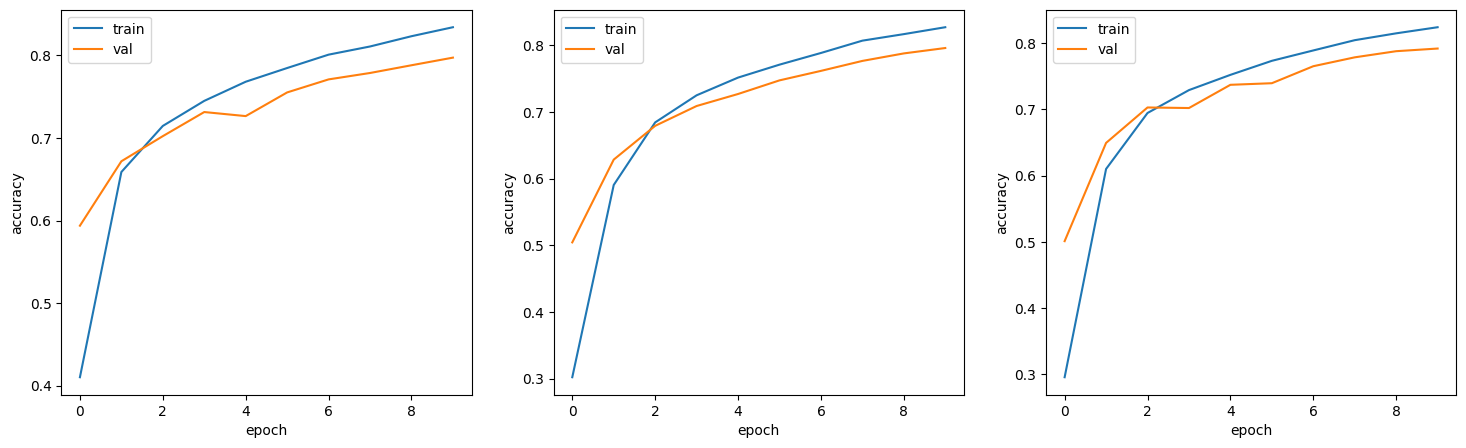

In [16]:
POS_utility.plot_single_runs(baseline_hist)

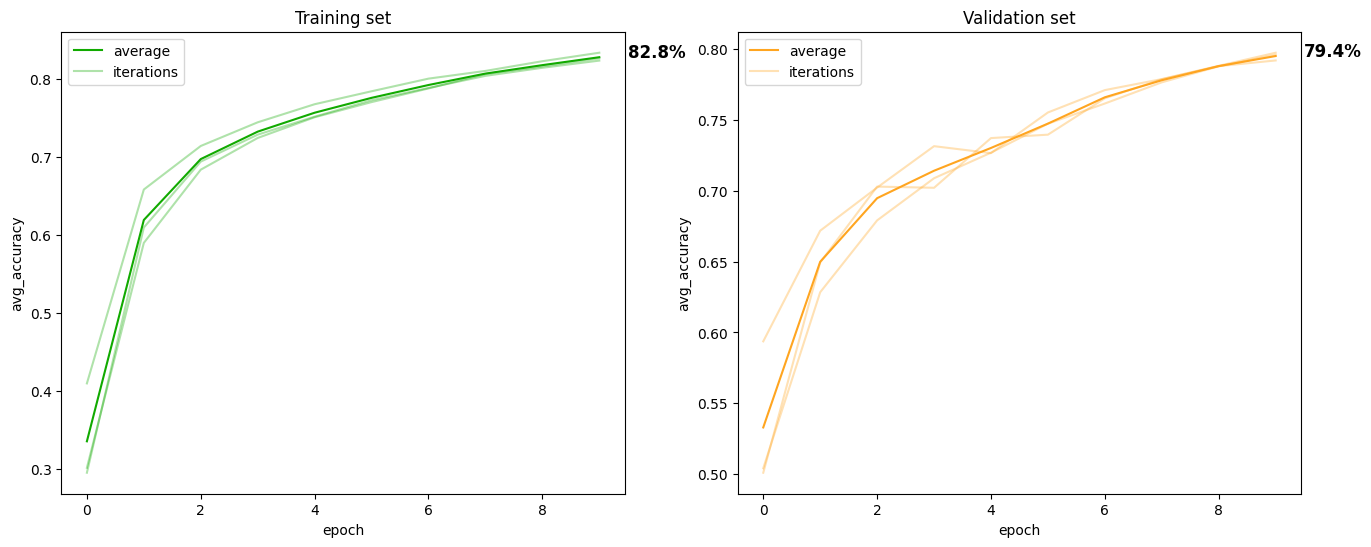

In [17]:
POS_utility.plot_averages(baseline_hist)

In [18]:
# Building the Test Set, analogously to the Validation Set
test_embed = df[df['set']=='test']['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in test_embed.index[~test_embed.apply(any)]:
    test_embed[i] = OOV_embed  # Using a static embedding for OOV words
test_X = np.stack(test_embed.to_numpy()).astype('float32')
test_y = df[df['set']=='test']['POS'].to_numpy()
test_y = encoder.transform(test_y)

In [19]:
scores_dicts = POS_utility.evaluate_model(baseline_model, ckp_folder.joinpath('baseline'),
                                          test_X, test_y, macro_F1_score, len(random_seeds))
# Evaluating the model implies testing the best checkpoint for every run on the Test Set,
# using the previously defined Macro F1 Score
print("\nAverage Macro F1 Score = ", np.mean([x["Macro_F1"] for x in scores_dicts]),"\n")
# After that, we plot all classes that got an F1 score below 0.5
print(POS_utility.errors_summary(scores_dicts, encoder, train_y, test_y))

Testing model n.1
486/486 - 5s - 5s/epoch - 11ms/step
Testing model n.2
486/486 - 3s - 3s/epoch - 6ms/step
Testing model n.3
486/486 - 3s - 3s/epoch - 6ms/step

Average Macro F1 Score =  0.6855740359255873 

   POS class train count test count     score
0      -LRB-           0         18       0.0
1      -RRB-           0         18       0.0
2         JJ        2824        918  0.576923
3        JJR         157         59     0.125
4         NN        6205       2383  0.695831
5        NNP        5022       1504  0.639232
6       NNPS          95         44       0.0
7        NNS        2978        941  0.695732
8        PDT           9          4       0.0
9         RB        1490        381  0.553672
10       RBR          86         15  0.433333
11       RBS          19          3       0.0
12        RP         140         33      0.48
13        VB        1194        403  0.587601
14       VBG         763        221   0.55409
15       VBN        1031        366   0.46225
16       V

# 6) A second Approach

<p>&nbsp;</p>

#### What we've been doing up until now is training a network using one word at a time, since the embeddings could be fed really easily as a sequence to the LSTM; however, using one whole sentece at a time could provide the model with additional information regarding the context around each word; therefore, here we repeat the whole pipeline using a dataset of complete sentences.

In [20]:
pd.options.mode.chained_assignment = None  # Necessary to avoid overwriting data

# Here we build a Dataframe composed of sequences, indexed by "Sentence_ID";
# we split them to obtain an array of words and we embed to each of them.
df_seq_train_X = df[df['set']=='train'][oov_mask].groupby(['Sentence_ID'])['text'].apply(' '.join).reset_index()
df_seq_train_X['text'] = df_seq_train_X['text'].apply(str.split)
df_seq_train_X['text'] = df_seq_train_X['text'].apply(lambda x: [embedding_matrix_vocab[word_index[j]] for j in x])
print("Training set encodings:")
print(df_seq_train_X.head())

df_seq_train_Y = df[df['set']=='train'][oov_mask].groupby(['Sentence_ID'])['POS'].apply(' '.join).reset_index()
df_seq_train_Y['POS'] = df_seq_train_Y['POS'].apply(str.split)
print("Training set POS:")
print(df_seq_train_Y.head())

val_embed = df[['Sentence_ID','text']][df['set']=='val'].copy(deep=True)
val_embed['text'] = val_embed['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in val_embed.index[~val_embed['text'].apply(any)]:
    val_embed['text'][i] = OOV_embed  # Using a static embedding for OOV words

df_seq_val_X = val_embed.groupby(['Sentence_ID'])['text'].apply(lambda x: [x]).reset_index()
df_seq_val_X['text'] = df_seq_val_X['text'].apply(np.squeeze)
df_seq_val_Y = df[df['set']=='val'].groupby(['Sentence_ID'])['POS'].apply(' '.join).reset_index()
df_seq_val_Y['POS'] = df_seq_val_Y['POS'].apply(str.split)
print("Validation set encodings:")
print(df_seq_val_X.head())
print("Validation set POS:")
print(df_seq_val_Y.head())

Training set encodings:
   Sentence_ID                                               text
0            1  [[-0.42798998951911926, -0.4792400002479553, -...
1            2  [[0.4851300120353699, 0.2844200134277344, -0.1...
2            3  [[-0.2708599865436554, 0.04400600120425224, -0...
3            4  [[0.1277800053358078, 0.4896000027656555, 0.45...
4            5  [[0.07251100242137909, -0.1062299981713295, -0...
Training set POS:
   Sentence_ID                                                POS
0            1  [NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, IN, D...
1            2  [NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP...
2            3  [DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS...
3            4  [NNS, IN, JJ, NNS, VBD, TO, VB, ,, IN, NNS, IN...
4            5  [NNP, NNP, ,, NN, NN, IN, NNP, NNP, CC, NNP, ,...
Validation set encodings:
   Sentence_ID                                               text
0          101  [[-0.2708599865436554, 0.04400600120425224, -0...
1       

In [21]:
# Then we convert the Dataframes to Numpy Arrays to be used in Tensorflow 
seq_train_X = df_seq_train_X['text'].apply(lambda x: np.stack(np.array(x)))
print("Training set shape:")
print(type(seq_train_X),type(seq_train_X[0]),type(seq_train_X[0][0]),type(seq_train_X[0][0][0]))
seq_train_y = df_seq_train_Y['POS'].apply(lambda x: np.array(encoder.transform(x)).astype(float))
print("Training labels:")
print(type(seq_train_y),type(seq_train_y[0]),type(seq_train_y[0][0]))

seq_val_X = df_seq_val_X['text'].apply(lambda x: np.stack(np.array(x)))
seq_val_y = df_seq_val_Y['POS'].apply(lambda x: np.array(encoder.transform(x)).astype(float))

# Finally, we pad our sequences to fit everything into a 3-dimensional Numpy Array
seq_train_X = POS_utility.pad_sentences(seq_train_X, embedding_dim)
seq_val_X = POS_utility.pad_sentences(seq_val_X, embedding_dim)
seq_train_y = np.column_stack(list(itertools.zip_longest(*seq_train_y, fillvalue=0.)))
seq_val_y = np.column_stack(list(itertools.zip_longest(*seq_val_y, fillvalue=0.)))

Training set shape:
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.float64'>
Training labels:
<class 'pandas.core.series.Series'> <class 'numpy.ndarray'> <class 'numpy.float64'>
Final Shape (sentences, sentence length, embedding dimensions):
(100, 2841, 100)
Final Shape (sentences, sentence length, embedding dimensions):
(50, 4534, 100)


#### Now that the Data is ready, we build our baseline model, train it the exact same way we did with the single-word one, we evaluate it and compare the results

In [22]:
seq_baseline = POS_utility.build_seq_model(BASE_LSTM, len(df['POS'].unique()), "baseline_seq_model")
seq_baseline.summary()

Model: "baseline_seq_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, None, 100)         0         
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 time_distributed (TimeDistr  (None, None, 45)         9045      
 ibuted)                                                         
                                                                 
Total params: 169,845
Trainable params: 169,845
Non-trainable params: 0
_________________________________________________________________


In [23]:
if DO_TRAINING:
    seq_baseline_hist = POS_utility.impermanent_training(
        seq_baseline, ckp_folder.joinpath('seq_baseline'), seq_train_X, seq_train_y,
        seq_val_X, seq_val_y,seeds=random_seeds, batch_size=1, epochs=10)
    with open(ckp_folder.joinpath('seqHistoryDict'), 'wb') as file_pi:
        pickle.dump(seq_baseline_hist, file_pi)
else:
    with open(ckp_folder.joinpath('seqHistoryDict'), "rb") as file_pi:
        seq_baseline_hist = pickle.load(file_pi)

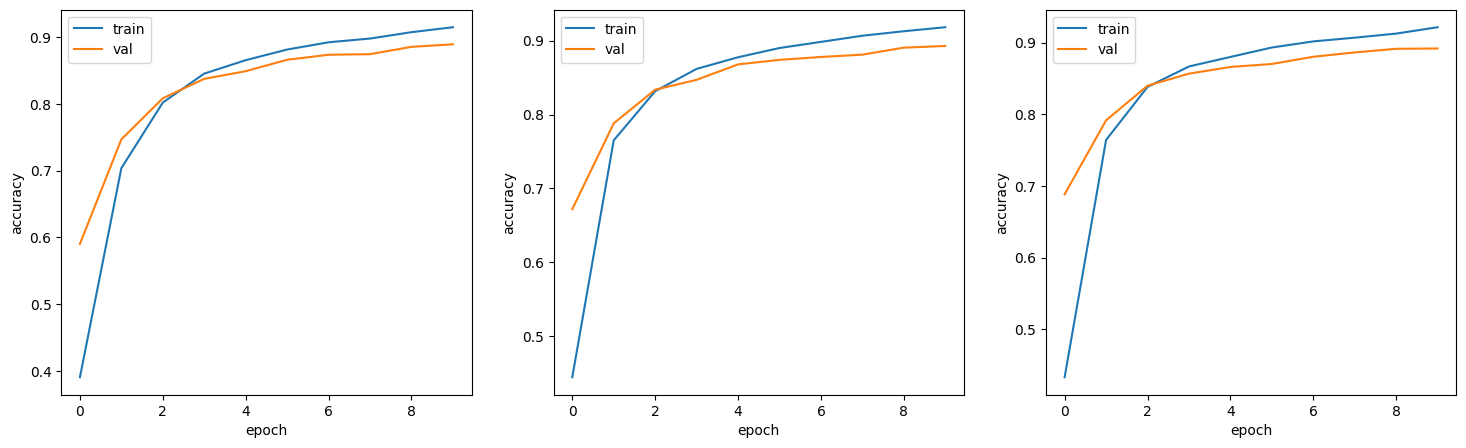

In [24]:
POS_utility.plot_single_runs(seq_baseline_hist)

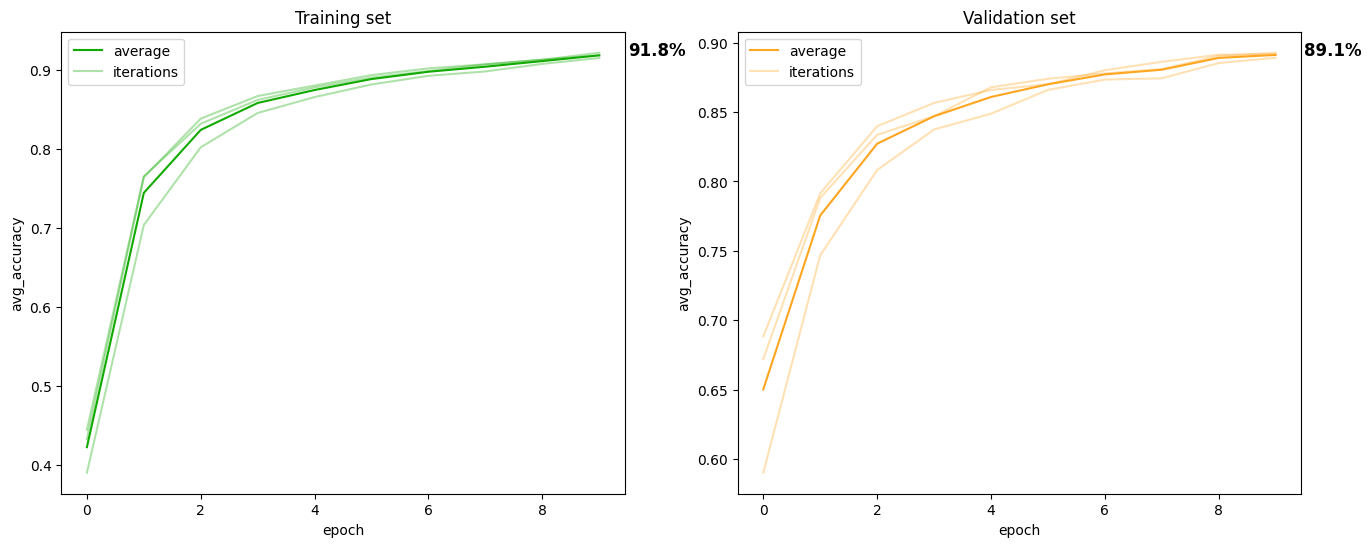

In [25]:
POS_utility.plot_averages(seq_baseline_hist)

In [26]:
# Same pre-processing pipeline for the Test Set
test_embed = df[['Sentence_ID','text']][df['set']=='test'].copy(deep=True)
test_embed['text'] = test_embed['text'].apply(lambda x: embedding_matrix_vocab[word_index[x]])
for i in test_embed.index[~test_embed['text'].apply(any)]:
    test_embed['text'][i] = OOV_embed  # Using a static embedding for OOV words

df_seq_test_X = test_embed.groupby(['Sentence_ID'])['text'].apply(lambda x: [x]).reset_index()
df_seq_test_X['text'] = df_seq_test_X['text'].apply(np.squeeze)
df_seq_test_Y = df[df['set']=='test'].groupby(['Sentence_ID'])['POS'].apply(' '.join).reset_index()
df_seq_test_Y['POS'] = df_seq_test_Y['POS'].apply(str.split)

seq_test_X = df_seq_test_X['text'].apply(lambda x: np.stack(np.array(x)))
seq_test_y = df_seq_test_Y['POS'].apply(lambda x: np.array(encoder.transform(x)).astype(float))

seq_test_X = POS_utility.pad_sentences(seq_test_X, embedding_dim)
seq_test_y = np.column_stack(list(itertools.zip_longest(*seq_test_y, fillvalue=0.)))


Final Shape (sentences, sentence length, embedding dimensions):
(49, 1492, 100)


In [27]:
seq_scores_dicts = POS_utility.evaluate_model(seq_baseline, ckp_folder.joinpath('seq_baseline'),
                                              seq_test_X, seq_test_y, macro_F1_score, len(random_seeds),
                                              sequences=True)
print("Average Macro F1 Score = ", np.mean([x["Macro_F1"] for x in seq_scores_dicts]),"\n")
print(POS_utility.errors_summary(seq_scores_dicts, encoder, train_y, test_y))

Testing model n.1
2/2 - 2s - 2s/epoch - 1s/step
Testing model n.2
2/2 - 0s - 167ms/epoch - 84ms/step
Testing model n.3
2/2 - 0s - 189ms/epoch - 94ms/step
Average Macro F1 Score =  0.6900713228309222 

   POS class train count test count     score
0      -LRB-           0         18       0.0
1      -RRB-           0         18       0.0
2         JJ        2824        918  0.749308
3        JJR         157         59  0.606742
4        JJS          93         31  0.315789
5       NNPS          95         44       0.0
6        PDT           9          4       0.0
7         RB        1490        381  0.010389
8        RBR          86         15  0.466667
9        RBS          19          3       0.5
10        RP         140         33  0.626506
11       VBG         763        221  0.715736
12       VBN        1031        366  0.728659
13       WP$           6          4       0.0


# 7) Assessing Baseline results & Further Training

<p>&nbsp;</p>

#### The two approaches, single words and whole sentences, produced both good results in accuracy but not so great results in Macro F1 Score: even if the second approach obtained an accuracy of 89% (an improvement of 9% over the previous model!), its F1 Score remained at 0.690, a mere 0.005 increase. This is probably due to two reasons:
<p>&nbsp;</p>

#### 1. Class disparity: since in the Macro F1 Score each class' score is averaged equally, having a huge increase in a very big class could have very little impact if another, smaller class still has lots of misclassified samples; this could be solved by weighting the dataset in order to give more importance to smaller classes.

#### 2. Dataset disparity: in our Error Summary (DataFrame output of the cell above) we can see that some classes either have very few samples in the Training Set to learn from (class WP$ only has 6 elements) or do not appear at all in it, like -LRB- and -RRB-, so the model is unlikely to reach a very high Macro F1 Score.
<p>&nbsp;</p>

#### Either way, we'll try using more complex models to see if they can improve our base results.


#### Since it got a slightly higher F1 Score, we'll stick with the Sentences method.

In [28]:
model_1 = POS_utility.build_seq_model(BASE_LSTM, len(df['POS'].unique()), "additional_LSTM_model",
                           [Bidirectional(LSTM(BASE_LSTM * 2, return_sequences=True))])
model_1.summary()

Model: "additional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_1 (Masking)         (None, None, 100)         0         
                                                                 
 bidirectional_3 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 400)        641600    
 nal)                                                            
                                                                 
 time_distributed_1 (TimeDis  (None, None, 45)         18045     
 tributed)                                                       
                                                                 
Total params: 820,445
Trainable params: 820,445
Non-trainable params: 0
_______________________________________

In [29]:
DO_ADDITIONAL_TRAINING = False

if DO_ADDITIONAL_TRAINING:
    model_1_hist = POS_utility.impermanent_training(
        model_1, ckp_folder.joinpath('model_1'), seq_train_X, seq_train_y,
        seq_val_X, seq_val_y,seeds=random_seeds, batch_size=1, epochs=10)
    with open(ckp_folder.joinpath('model1HistoryDict'), 'wb') as file_pi:
        pickle.dump(model_1_hist, file_pi)
else:
    with open(ckp_folder.joinpath('model1HistoryDict'), "rb") as file_pi:
        model_1_hist = pickle.load(file_pi)

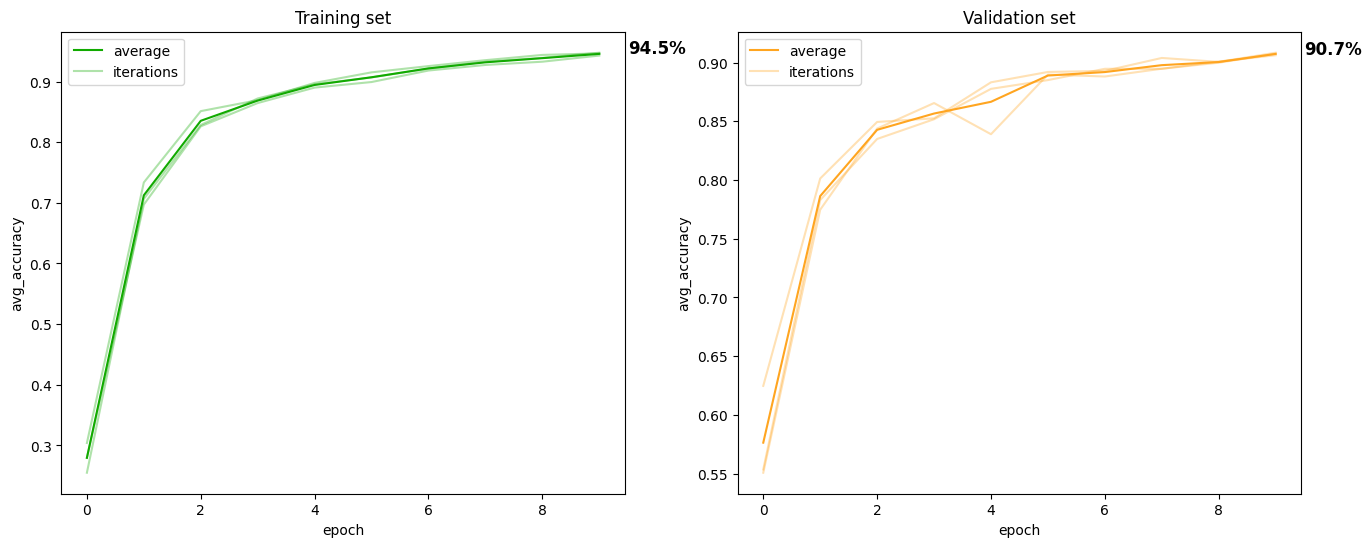

In [30]:
POS_utility.plot_averages(model_1_hist)

In [31]:
model_1_scores = POS_utility.evaluate_model(model_1, ckp_folder.joinpath('model_1'),
                                            seq_test_X, seq_test_y, macro_F1_score, len(random_seeds),
                                            sequences=True)
print("Average Macro F1 Score = ", np.mean([x["Macro_F1"] for x in model_1_scores]),"\n")
print(POS_utility.errors_summary(model_1_scores, encoder, train_y, test_y))

Testing model n.1
2/2 - 4s - 4s/epoch - 2s/step
Testing model n.2
2/2 - 0s - 334ms/epoch - 167ms/step
Testing model n.3
2/2 - 0s - 326ms/epoch - 163ms/step
Average Macro F1 Score =  0.7655624358494851 

  POS class train count test count     score
0     -LRB-           0         18       0.0
1     -RRB-           0         18       0.0
2      NNPS          95         44  0.083333
3       PDT           9          4       0.0
4        RB        1490        381   0.01056
5       RBR          86         15  0.551724
6        RP         140         33  0.682927
7       WP$           6          4  0.666667


In [32]:
model_2 = POS_utility.build_seq_model(BASE_LSTM, len(df['POS'].unique()), "additional_LSTM_model",
                           [TimeDistributed(Dense(1024, activation='ReLU',
                                                  activity_regularizer=keras.regularizers.L2(0.01)))])
model_2.summary()

Model: "additional_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_2 (Masking)         (None, None, 100)         0         
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 200)        160800    
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, None, 1024)       205824    
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 45)         46125     
 tributed)                                                       
                                                                 
Total params: 412,749
Trainable params: 412,749
Non-trainable params: 0
_______________________________________

In [33]:
if DO_ADDITIONAL_TRAINING:
    model_2_hist = POS_utility.impermanent_training(
        model_2, ckp_folder.joinpath('model_2'), seq_train_X, seq_train_y,
        seq_val_X, seq_val_y,seeds=random_seeds, batch_size=1, epochs=10)
    with open(ckp_folder.joinpath('model2HistoryDict'), 'wb') as file_pi:
        pickle.dump(model_2_hist, file_pi)
else:
    with open(ckp_folder.joinpath('model2HistoryDict'), "rb") as file_pi:
        model_2_hist = pickle.load(file_pi)

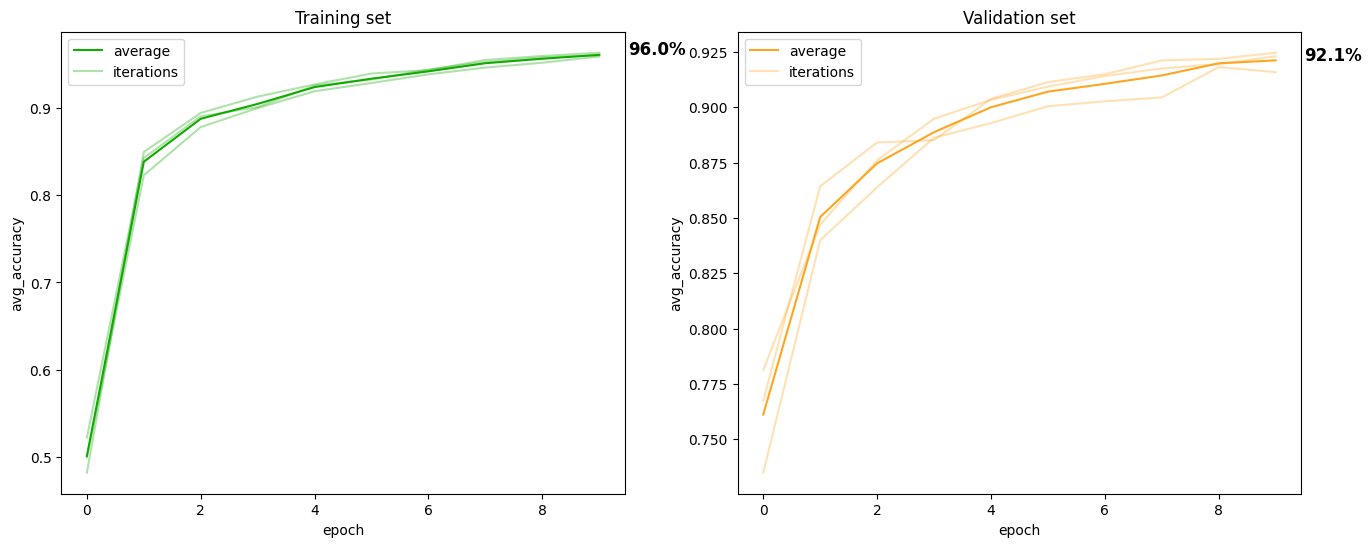

In [34]:
POS_utility.plot_averages(model_2_hist)

In [35]:
model_2_scores = POS_utility.evaluate_model(model_2, ckp_folder.joinpath('model_2'),
                                            seq_test_X, seq_test_y, macro_F1_score, len(random_seeds),
                                            sequences=True)
print("Average Macro F1 Score = ", np.mean([x["Macro_F1"] for x in model_2_scores]),"\n")
print(POS_utility.errors_summary(model_2_scores, encoder, train_y, test_y))

Testing model n.1
2/2 - 2s - 2s/epoch - 1s/step
Testing model n.2
2/2 - 0s - 168ms/epoch - 84ms/step
Testing model n.3
2/2 - 0s - 194ms/epoch - 97ms/step
Average Macro F1 Score =  0.7636309673675726 

  POS class train count test count     score
0     -LRB-           0         18       0.0
1     -RRB-           0         18       0.0
2        NN        6205       2383  0.070575
3      NNPS          95         44       0.0
4       PDT           9          4       0.0
5       RBR          86         15      0.48
6       RBS          19          3       0.0
7        RP         140         33  0.632911
8       WP$           6          4       0.0


# 8) Final Evaluation

<p>&nbsp;</p>

#### In the end, even if the additional Dense layer managed to reach a higher accuracy (92%!) and had overall a more stable training, while the additional LSTM layer created a much "wobblier" graph, the latter also performed better on the Macro F1 Score, which is what ultimately concerns us.

#### Not only it got a slightly higher value (0.765 > 0.763), but only 5 classes had a score below 0.5, and of those only three got a net 0, two of which did not appear at all in the Training Set (while in the Dense layer model there are eight classes below 0.5, of which six got exactly 0). 

<p>&nbsp;</p>

#### Before closing up the assignment, we'll try to improve the LSTM model a little further by boosting the classes with low F1 Scores, like NNPS and RB.

In [36]:
model_1_scores = POS_utility.evaluate_model(model_1, ckp_folder.joinpath('model_1'),
                                    seq_val_X, seq_val_y, macro_F1_score, len(random_seeds),
                                    sequences=True)
to_improve = POS_utility.errors_summary(model_1_scores, encoder, train_y, val_y)
# Determining what classes to boost using the Validation Set, since in a real-world scenario
# we would not have access to the Test Set.

class_weight = {}
for w in encoder.transform(df['POS'].unique()):
    class_weight[w] = 1.
for c in range(len(to_improve)):
    row = to_improve.iloc[c]
    if row['train count'] > 0:
        class_weight[encoder.transform([row['POS class']])[0]] = (1 - row['score']) * 10
        # Setting a weight for each misclassified class indirectly proportional to its F1 Score

Testing model n.1
2/2 - 4s - 4s/epoch - 2s/step
Testing model n.2
2/2 - 1s - 842ms/epoch - 421ms/step
Testing model n.3
2/2 - 1s - 841ms/epoch - 420ms/step


In [37]:
DO_FINAL_TRAINING = False

if DO_FINAL_TRAINING:
    model_1_hist_b = POS_utility.impermanent_training(
        model_1, ckp_folder.joinpath('model_b'), seq_train_X, seq_train_y,
        seq_val_X, seq_val_y,seeds=random_seeds, batch_size=1, epochs=20)
    # Fine-tuning starting from the best weights found of the model 1
    with open(ckp_folder.joinpath('modelbHistoryDict'), 'wb') as file_pi:
        pickle.dump(model_1_hist, file_pi)
else:
    with open(ckp_folder.joinpath('modelbHistoryDict'), "rb") as file_pi:
        model_1_hist_b = pickle.load(file_pi)

In [38]:
importlib.reload(POS_utility)
model_1b_scores = POS_utility.evaluate_model(model_1, ckp_folder.joinpath('model_b'),
                                            seq_test_X, seq_test_y, macro_F1_score, len(random_seeds),
                                            sequences=True)
print("\nAverage Macro F1 Score = ", np.mean([x["Macro_F1"] for x in model_1b_scores]))
mean_acc = np.mean([model_1_hist_b[x]['val_accuracy'][-1] for x in range(len(random_seeds))])
print("Average Validation Set Accuracy = ", mean_acc,"\n")
print(POS_utility.errors_summary(model_1b_scores, encoder, train_y, test_y))

Testing model n.1
2/2 - 0s - 487ms/epoch - 243ms/step
Testing model n.2
2/2 - 0s - 318ms/epoch - 159ms/step
Testing model n.3
2/2 - 0s - 300ms/epoch - 150ms/step

Average Macro F1 Score =  0.7966791623215546
Average Validation Set Accuracy =  0.9074709614117941 

  POS class train count test count     score
0     -LRB-           0         18       0.0
1     -RRB-           0         18       0.0
2      NNPS          95         44  0.285714
3       PDT           9          4       0.4
4        RB        1490        381  0.010564
5       RBR          86         15    0.5625
6        RP         140         33  0.657534


# Conclusions

<p>&nbsp;</p>

#### After fine-tuning on the best-performing model, boosting the classes that got a lower score, we improved our Macro F1 Score by a non-negligible margin, going from 0.765 to 0.796 (and improving our baseline from 0.690, an increase of more than 0.1). Not only that, but also now only the two classes that did not appear at all in the Training Set have a net 0 in F1 Score, meaning that every class seen at least once by the model could be classified correctly.

#### The difficulties of this task came for sure from a heaviliy imbalanced dataset, embeddings not fine-tuned for the corpus at hand and limited options while building our models. The F1 score is a metric that "treats all classes equally", therefore it really highlights all the problems. 

<p>&nbsp;</p>

#### However, in other environments this task can be (and has been) tackled much more efficiently with much better results, as can be seen [here](https://arxiv.org/abs/2104.07951) or even [here](https://arxiv.org/abs/2305.13989), with much less documented languages.